In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

--2023-10-06 14:34:47--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1,4M) [text/plain]
Saving to: ‘data.csv.1’

data.csv.1          100%[===================>]   1,41M  51,1KB/s    in 30s     

2023-10-06 14:35:18 (48,7 KB/s) - ‘data.csv.1’ saved [1475504/1475504]



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv("./data.csv")
df

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11909,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,46120
11910,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,56670
11911,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,50620
11912,Acura,ZDX,2013,premium unleaded (recommended),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,50920


## Data Preparation

In [3]:
df.columns

Index(['Make', 'Model', 'Year', 'Engine Fuel Type', 'Engine HP',
       'Engine Cylinders', 'Transmission Type', 'Driven_Wheels',
       'Number of Doors', 'Market Category', 'Vehicle Size', 'Vehicle Style',
       'highway MPG', 'city mpg', 'Popularity', 'MSRP'],
      dtype='object')

In [4]:
df = df.drop(columns=["Engine Fuel Type", "Driven_Wheels", "Number of Doors", "Market Category", "Vehicle Size", "Popularity"])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine HP          11845 non-null  float64
 4   Engine Cylinders   11884 non-null  float64
 5   Transmission Type  11914 non-null  object 
 6   Vehicle Style      11914 non-null  object 
 7   highway MPG        11914 non-null  int64  
 8   city mpg           11914 non-null  int64  
 9   MSRP               11914 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 930.9+ KB


In [6]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

In [7]:
df = df.fillna(0)

In [8]:
mean = df["msrp"].mean()

In [9]:
(df["msrp"] >= mean).values.astype(int)

array([1, 1, 0, ..., 1, 1, 0])

In [10]:
df["above_average"] = (df["msrp"] >= mean).values.astype(int)

In [11]:
data = df.copy()
data = data.drop(columns="msrp")

In [12]:
# Splitting dataset
df_training, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(data, test_size=0.2, random_state=1)

In [13]:
df_train.reset_index(drop=True)
df_val.reset_index(drop=True)
df_test.reset_index(drop=True)

y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

In [14]:
del df_train["above_average"]
del df_val["above_average"]
del df_test["above_average"]

## Question 1

In [15]:
numerical = list(df_train.select_dtypes("number"))
numerical

['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

In [16]:
for c in numerical:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print('%9s, %.3f' % (c, auc))
    #print(c, auc)

     year, 0.688
engine_hp, 0.917
engine_cylinders, 0.767
highway_mpg, 0.632
 city_mpg, 0.673


#### The numerical variable who has the highest AUC is engine_cylinders.

## Question 2

In [17]:
# One hot encoder
train_dict = df_train.to_dict(orient = "records")
dict_vectorizer = DictVectorizer(sparse="False")
X = dict_vectorizer.fit_transform(train_dict)

In [18]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [19]:
val_dict = df_val.to_dict(orient = "records")
X_val = dict_vectorizer.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

In [20]:
auc_val = roc_auc_score(y_val, y_pred)
print(auc_val.round(3))

0.979


#### The AUC of this model on the validation dataset is 0.979.

## Question 3

In [21]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['recall'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [22]:
df_scores = tpr_fpr_dataframe(y_val, y_pred)

In [23]:
df_scores.head()

,threshold,tp,fp,fn,tn,precision,recall
0,0.00,662,1721,0,0,1.000000,1.000000
1,0.01,660,812,2,909,0.996979,0.471819
2,0.02,660,650,2,1071,0.996979,0.377687
3,0.03,660,588,2,1133,0.996979,0.341662
4,0.04,660,537,2,1184,0.996979,0.312028


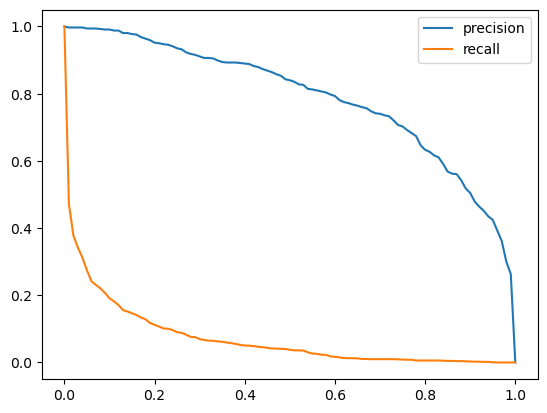

In [24]:
plt.plot(df_scores.threshold, df_scores.precision, label="precision")
plt.plot(df_scores.threshold, df_scores.recall, label="recall")
plt.legend()

## The threshold precision and recall curves intersect in ~0.48.

## Question 4

In [25]:
df_scores["F1"] = 2 * (df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall)

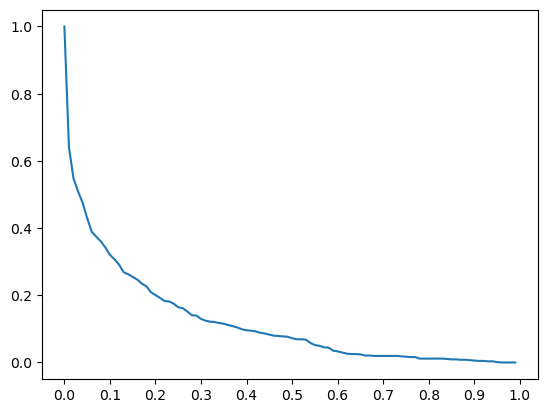

In [26]:
plt.plot(df_scores.threshold, df_scores.F1)
plt.xticks(np.linspace(0, 1, 11))
plt.show()

#### The threshold F1 maximal is 0.52.

## Question 5

In [32]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_training):
    df_train = df_training.iloc[train_idx]
    df_val = df_training.iloc[val_idx]

    y_train = df_train.above_average
    y_val = df_val.above_average

    train = df_train.to_dict(orient = "records")
    dict_vectorizer = DictVectorizer(sparse="False")
    X_train = dict_vectorizer.fit_transform(train)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    val = df_val.to_dict(orient = "records")
    X_vald = dict_vectorizer.transform(val)
    y_predict = model.predict_proba(X_vald)[:, 1]

    auc = roc_auc_score(y_val, y_predict)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

1.000 +- 0.000


#### The standard deviation of the scores across different folds is .

## Question 6

In [30]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.01, 0.1, 0.5, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_training):
        df_train = df_training.iloc[train_idx]
        df_val = df_training.iloc[val_idx]

        y_train = df_train.above_average
        y_val = df_val.above_average
        
        train = df_train.to_dict(orient = "records")
        dict_vect = DictVectorizer(sparse="False")
        X_train = dict_vect.fit_transform(train)

        model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
        model.fit(X_train, y_train)

        val = df_val.to_dict(orient = "records")
        X_vald = dict_vect.transform(val)
        y_predict = model.predict_proba(X_vald)[:, 1]

        auc = roc_auc_score(y_val, y_predict)
        scores.append(auc)

    print('C=%4s, %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01, 1.000 +- 0.000
C= 0.1, 1.000 +- 0.000
C= 0.5, 1.000 +- 0.000
C=  10, 1.000 +- 0.000


#### The leads to the best mean score is 0.5.